# Projet : Détection des Fissures (Crack Detection)


## Introduction:
Les fissures sur les surfaces en béton constituent un défaut majeur dans les structures civiles. L'inspection des bâtiments, qui vise à évaluer leur rigidité et leur résistance à la traction, repose en grande partie sur la détection des fissures. Cette détection joue un rôle essentiel dans l'évaluation de l'état de santé des bâtiments.

Dans ce projet, l'objectif est de développer un modèle basé sur les réseaux de neurones convolutifs (CNN) afin de classifier les images de surfaces de béton en deux classes : avec fissures et sans fissures.

 Le jeu de données, provenant de **Kaggle**, comprend 40 000 images RGB de 227 x 227 pixels, réparties également entre les deux classes. Ce dataset est accessible via le lien suivant : [https://www.kaggle.com/datasets/arunrk7/surface-crack-detection/data]

Les étapes du projets sont:

- Préparation des données : division en ensembles (entraînement, validation, test) et exploration des caractéristiques.

- Conception et entraînement du modèle CNN : création du modèle, entraînement, validation, et évaluation sur un ensemble de test.
- Conclusion


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import sklearn
from sklearn.model_selection import train_test_split

import os
import PIL

import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import torch.nn as nn



In [ ]:
# Définir une valeur de départ aléatoire (seed).
random_seed = 124

# Définit le seed pour le générateur de nombres aléatoires de NumPy.
np.random.seed(random_seed)

# Définit le seed pour le générateur de nombres aléatoires de PyTorch.
torch.manual_seed(random_seed)

# Définit le drapeau "deterministic" pour le backend CUDA de PyTorch à True.
torch.backends.cudnn.deterministic = True

In [ ]:
# Détermine le périphérique à utiliser pour les calculs (GPU ou CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Affiche le périphérique sélectionné (soit "cuda" ou "cpu").
device

device(type='cpu')

In [ ]:
# Télécharge le dataset "Surface Crack Detection" depuis Kaggle en utilisant l'outil CLI de Kaggle.
!kaggle datasets download -d arunrk7/surface-crack-detection


Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
 97% 227M/233M [00:02<00:00, 92.7MB/s]
100% 233M/233M [00:02<00:00, 96.8MB/s]


In [ ]:
# Crée une archive ZIP nommée "surface-crack-detection-data.zip"
# contenant tous les fichiers et sous-dossiers du répertoire "data".
!zip -r surface-crack-detection-data.zip ./data > /dev/null


In [ ]:
# Décompresse le fichier "surface-crack-detection.zip" dans le dossier "./data" et supprime les messages de sortie pour un affichage propre.
!unzip surface-crack-detection.zip -d ./data > /dev/null


# **Préparation des données:**

### Génération des labels et division des données pour le train et le test:
Nos images sont stockés dans les fichiers Postive et négative, mais ne sont pas encore labelisées. Dans cette partie, nous allons créer un vecteur qui va contenir les labels de toutes les images. Nous allons coder par 1 les images qui présentent des fissures et par 0 les images qui n'ont pas des fissures.

In [ ]:
# Création des labels
image_dir = './data/'
pos_images = glob.glob(image_dir + 'Positive/*.jpg')
neg_images = glob.glob(image_dir + 'Negative/*.jpg')

images = pos_images + neg_images
labels = np.array([1] * len(pos_images) + [0] * len(neg_images))

L'une des pratiques les plus indispensables en machine learning est la division du jeu de données en trois ensembles : jeu d'entraînement, jeu de validation, et jeu de test. Cette division permet de garantir une bonne évaluation et généralisation du modèle.

Nous allons maintenant procéder à la division de nos données afin de créer ces trois ensembles et de préparer notre pipeline d'apprentissage.

In [ ]:
# Division des donnnées
images_tv, images_test, labels_tv, labels_test = train_test_split(images, labels, test_size=0.2, random_state=random_seed)

images_train, images_val, labels_train, labels_val = train_test_split(images_tv, labels_tv, test_size=0.2, random_state=random_seed)
print(f"taiile du jeu de données d'entraînement {len(images_train)}\ntaiile du jeu de données de validation: {len(images_val)} \ntaille du jeu de données de test {len(images_test)}")

taiile du jeu de données d'entraînement 25600
taiile du jeu de données de validation: 6400 
taille du jeu de données de test 8000


# Visualisons certaines images:


Il est toujours essentiel de réaliser une exploration des données avant de commencer l'entraînement d'un modèle. Cela permet de s'assurer que les données sont dans une forme adaptée pour une extraction efficace des caractéristiques. En effet, il peut arriver que les données présentent des anomalies, soient mal structurées ou contiennent du bruit. Dans de tels cas, il est recommandé d'appliquer des filtrages ou des transformations pour améliorer leur qualité et faciliter le processus d'apprentissage.

Image avec fissures:

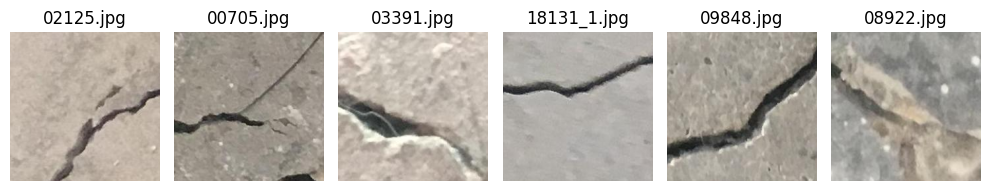

In [ ]:
# Chemin vers le dossier où les images
pos_dir = './data/Positive/'

# Lister quelques fichiers du dossier
image_pos = os.listdir(pos_dir)[10:16]

# Afficher les images
plt.figure(figsize=(10, 5))
for i, file in enumerate(image_pos):
    image_path = os.path.join(pos_dir, file)
    img = PIL.Image.open(image_path)
    plt.subplot(1, len(image_pos), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()


Images sans fissures:

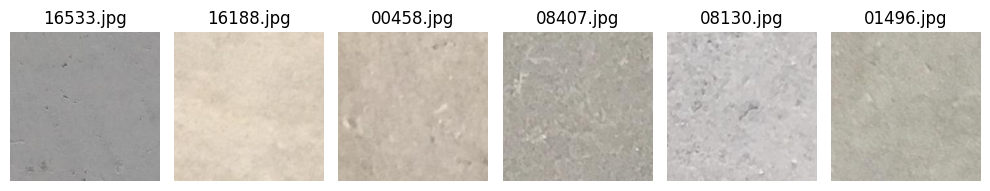

In [ ]:
# Chemin vers le dossier
neg_dir = './data/Negative/'

# Lister quelques fichiers du dossier
image_neg = os.listdir(neg_dir)[30:36]

# Afficher les images
plt.figure(figsize=(10, 5))
for i, file in enumerate(image_neg):
    image_path = os.path.join(neg_dir, file)
    img_neg = PIL.Image.open(image_path)
    plt.subplot(1, len(image_neg), i + 1)
    plt.imshow(img_neg, cmap='gray')
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Prétraitement des Images

Après visualisations de certaines images, nous avons constaté que les fissures sont orientées dans toutes les directions, rendant inutile l'application de rotations.

Les étapes de prétraitement que nous allons appliquer sont les suivantes :
1. **Conversion en niveaux de gris** : Les images sont converties en niveaux de gris (`Grayscale()`), ce qui simplifie l'analyse des fissures en supprimant les informations de couleur.
2. **Conversion en tenseur** : Les images sont transformées en tenseurs compatibles avec le modèle (`ToTensor()`).
3. **Normalisation** : Les valeurs des pixels sont normalisées avec une moyenne de 0.5 et un écart-type de 0.5 (`Normalize(mean=[0.5], std=[0.5])`), ce qui permet d'améliorer la stabilité numérique et la convergence du modèle pendant l'entraînement.



Ce pipeline assure une préparation optimale des données pour l'entraînement du modèle.

In [ ]:
img_transforms = transforms.Compose([
    transforms.Grayscale(),                                # Conversion en niveaux de gris
    transforms.ToTensor(),                                 # Conversion en Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])           # Normalisation pour un canal
])


Nous allons créer des classes permettant de charger, transformer et organiser les images pour qu'elles soient compatibles avec le modèle. On définit une classe de dataset personnalisée pour PyTorch, qui est utilisée pour charger et prétraiter des images avant leur passage dans un modèle d'apprentissage profond.

In [ ]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=True):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if (img_transforms is None) & (grayscale == True):
            self.transforms = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor()
            ])
        elif img_transforms is None and grayscale == False:
            self.transforms = transforms.Compose([
                transforms.ToTensor()
            ])
        else:
            self.transforms = img_transforms

    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')

        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]

    def __len__(self):
        return len(self.img_path)

# **Conception et entraînement du modèle :**  

Dans cette section, nous allons concevoir l'ensemble du pipeline pour la création, l'entraînement et l'évaluation de notre modèle CNN. Nous développerons la classe définissant l'architecture du modèle CNN. Enfin, nous implémenterons les fonctions nécessaires pour entraîner le modèle, valider ses performances sur un ensemble de validation et évaluer ses performances finales sur un ensemble de test.  

## Développement du modèle :  
Dans cette section, nous allons concevoir et implémenter un modèle CNN spécialement adapté à la classification des images. Ce modèle sera entraîné pour distinguer les surfaces avec fissures de celles sans fissures.  

In [ ]:
class Convnet(nn.Module):
    def __init__(self, dropout=0.5):
        super(Convnet, self).__init__()
        self.convnet = nn.Sequential(
            # Input: (num_batch, 1, 227, 227)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # (num_batch, 16, 227, 227)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (num_batch, 16, 113, 113)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # (num_batch, 32, 113, 113)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (num_batch, 32, 56, 56)

            nn.Flatten()  # (num_batch, 32 * 56 * 56)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features=32 * 56 * 56, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x


Visualisation de l'architecture:

In [ ]:
model = Convnet()
model.to(device)

# Affichage de l'architecture avec une entrée de taille (batch_size, 1, 227, 227)
summary(model, input_size=(1, 1, 227, 227))  # Ajout explicite de batch_size = 1


Layer (type:depth-idx)                   Output Shape              Param #
Convnet                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 100352]               --
│    └─Conv2d: 2-1                       [1, 16, 227, 227]         160
│    └─ReLU: 2-2                         [1, 16, 227, 227]         --
│    └─MaxPool2d: 2-3                    [1, 16, 113, 113]         --
│    └─Conv2d: 2-4                       [1, 32, 113, 113]         4,640
│    └─ReLU: 2-5                         [1, 32, 113, 113]         --
│    └─MaxPool2d: 2-6                    [1, 32, 56, 56]           --
│    └─Flatten: 2-7                      [1, 100352]               --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Dropout: 2-8                      [1, 100352]               --
│    └─Linear: 2-9                       [1, 128]                  12,845,184
│    └─ReLU: 2-10                        [1, 128]                  --
│  

## Entraînement du modèle:

Dans cette partie, nous allons créer une fonction qui entraine le modèles à partir des données d'entraînement.

In [ ]:
model = Convnet()

In [ ]:
# Chargement des données:
train_dataset = CT_Dataset(images_train, labels_train, img_transforms)
val_dataset = CT_Dataset(images_val, labels_val, img_transforms)
test_dataset = CT_Dataset(images_test, labels_test, img_transforms)

In [ ]:
# Hyperparamètres

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
epochs = 4
batch_size = 64

In [ ]:
def train_model(model, lr, train_dataset, val_dataset, criterion_func, epochs, batch_size, opt_func=optim.Adam):
    """ Cette fonction permet d'entrainer un modèle de deep learning.

    Args:
        model (torch.nn.Module): Le modèle de deep learning à entraîner.
        lr (float): La vitesse d'apprentissage.
        train_dataset (torch.utils.data.Dataset): Le jeu de données d'entraînement.
        val_dataset (torch.utils.data.Dataset): Le jeu de données de validation.
        criterion_func (torch.nn.Module): La fonction de perte.
        epochs (int): Le nombre d'époques d'entraînement.
        batch_size (int): La taille des lots.
        opt_func (torch.optim): L'optimiseur.

    Returns:
        model (torch.nn.Module): Le modèle entraîné.
        historique (dict): Un dictionnaire contenant l'historique de l'entraînement.
    """
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer and criterion
    optimizer = opt_func(model.parameters(), lr=lr)
    criterion = criterion_func

    # historique
    historique = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        correct_predictions = 0
        total_samples = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move data to the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images).view(-1)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accuracy computation
            correct_predictions += (pred == labels).sum().item()
            total_samples += labels.size(0)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_losses.append(loss.item())

            #
            print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")


        train_acc = correct_predictions / total_samples
        train_loss = np.mean(train_losses)

        # Validation phase
        model.eval()
        val_losses = []
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                # Move data to the appropriate device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images).view(-1)
                pred = torch.sigmoid(outputs)
                pred = torch.round(pred)

                # Compute loss
                loss = criterion(outputs, labels)

                # Accuracy computation
                correct_predictions += (pred == labels).sum().item()
                total_samples += labels.size(0)

                val_losses.append(loss.item())

                #
                print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(val_loader)}, Loss: {loss.item():.4f}")
        val_acc = correct_predictions / total_samples
        val_loss = np.mean(val_losses)



        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        historique['train_loss'].append(train_loss)
        historique['train_acc'].append(train_acc)
        historique['val_loss'].append(val_loss)
        historique['val_acc'].append(val_acc)

    return model, historique


In [ ]:
# entrainement
train_model(model, learning_rate, train_dataset, val_dataset, criterion,epochs, batch_size)

Epoch 1/4, Batch 1/400, Loss: 0.6926
Epoch 1/4, Batch 2/400, Loss: 2.4424
Epoch 1/4, Batch 3/400, Loss: 1.6763
Epoch 1/4, Batch 4/400, Loss: 1.5678
Epoch 1/4, Batch 5/400, Loss: 0.5791
Epoch 1/4, Batch 6/400, Loss: 0.5709
Epoch 1/4, Batch 7/400, Loss: 0.7267
Epoch 1/4, Batch 8/400, Loss: 0.4602
Epoch 1/4, Batch 9/400, Loss: 0.3150
Epoch 1/4, Batch 10/400, Loss: 0.3557
Epoch 1/4, Batch 11/400, Loss: 0.8429
Epoch 1/4, Batch 12/400, Loss: 0.3862
Epoch 1/4, Batch 13/400, Loss: 0.3097
Epoch 1/4, Batch 14/400, Loss: 0.3577
Epoch 1/4, Batch 15/400, Loss: 0.3382
Epoch 1/4, Batch 16/400, Loss: 0.2020
Epoch 1/4, Batch 17/400, Loss: 0.2876
Epoch 1/4, Batch 18/400, Loss: 0.3616
Epoch 1/4, Batch 19/400, Loss: 0.2118
Epoch 1/4, Batch 20/400, Loss: 0.2732
Epoch 1/4, Batch 21/400, Loss: 0.2354
Epoch 1/4, Batch 22/400, Loss: 0.1318
Epoch 1/4, Batch 23/400, Loss: 0.1558
Epoch 1/4, Batch 24/400, Loss: 0.1347
Epoch 1/4, Batch 25/400, Loss: 0.1305
Epoch 1/4, Batch 26/400, Loss: 0.2168
Epoch 1/4, Batch 27/4

(Convnet(
   (convnet): Sequential(
     (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Flatten(start_dim=1, end_dim=-1)
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=100352, out_features=128, bias=True)
     (2): ReLU()
     (3): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 {'train_loss': [0.08561638801438676,
   0.029744707825229852,
   0.01790837761316652,
   0.013230080339135385],
  'train_acc': [0.9739453125, 0.991640625, 0.99484375, 0.9968359375],
  'val_loss': [0.03913652435876429,
   0.05562914688140154,
   0.03774416284271865,
   0.029066201295136124],
  'val_acc': [0.988125, 0.985625, 0.9915625, 0

In [ ]:
# historique de l'entraînement
historique = {'train_loss': [0.08561638801438676,
   0.029744707825229852,
   0.01790837761316652,
   0.013230080339135385],
  'train_acc': [0.9739453125, 0.991640625, 0.99484375, 0.9968359375],
  'val_loss': [0.03913652435876429,
   0.05562914688140154,
   0.03774416284271865,
   0.029066201295136124],
  'val_acc': [0.988125, 0.985625, 0.9915625, 0.99359375]}

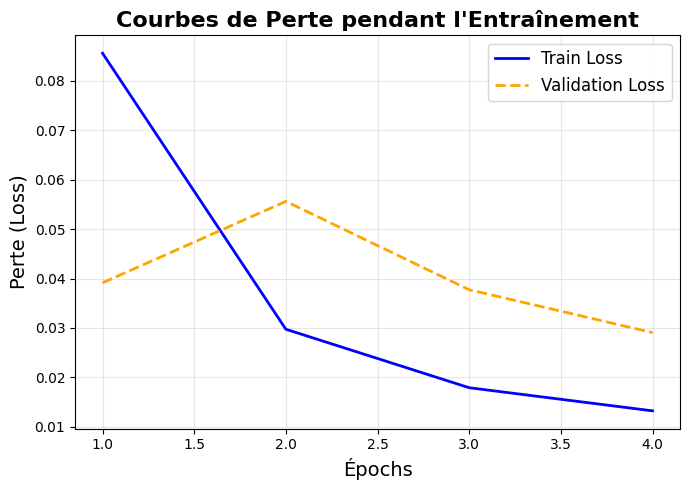

In [ ]:
# Courbes du loss
plt.figure(figsize=(7, 5))  # Taille de la figure
epochs = range(1, len(historique['train_loss']) + 1)  # Liste des Époques
plt.plot(epochs,historique['train_loss'], label='Train Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(epochs, historique['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('Courbes de Perte pendant l\'Entraînement', fontsize=16, fontweight='bold')  # Titre
plt.xlabel('Épochs', fontsize=14)  # Label axe x
plt.ylabel('Perte (Loss)', fontsize=14)  # Label axe y
plt.grid(alpha=0.3)  # Grille légère pour plus de lisibilité
plt.legend(fontsize=12)  # Légende avec une taille de police modérée
plt.tight_layout()  # Ajustement automatique des marges
plt.show()




Text(0.5, 0, 'Épochs')

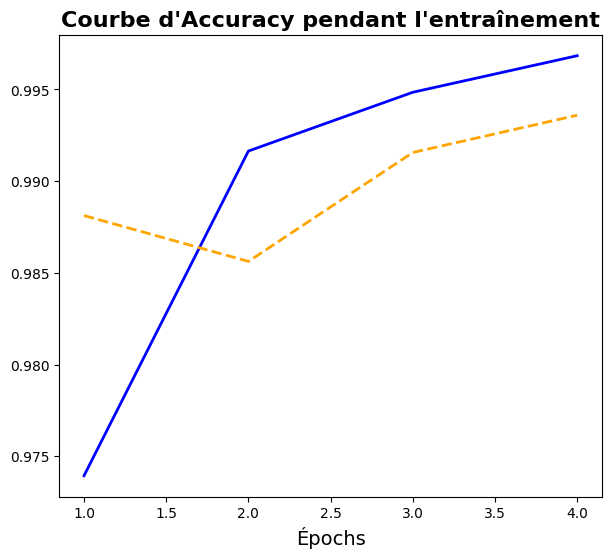

In [ ]:
# Courbe de l'accuracy
plt.figure(figsize=(7,6))
plt.plot(epochs, historique['train_acc'], label='Train Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(epochs, historique['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title("Courbe d'Accuracy pendant l'entraînement", fontsize=16, fontweight='bold')
plt.xlabel('Épochs', fontsize=14)

D'après les courbes présentées, nous observons des évolutions similaires pour la perte (loss) et la précision (accuracy) au cours des époques. La perte d'entraînement diminue significativement à partir de la deuxième époque, indiquant que le modèle apprend efficacement les motifs dans les données. En parallèle, la précision d'entraînement s'améliore progressivement. Pour les données de validation, une légère augmentation de la perte est visible lors de la deuxième époque, suivie d'une diminution aux troisième et quatrième époques. De même, la précision de validation fluctue légèrement avant de s'améliorer progressivement.

Ces résultats suggèrent que le modèle s'adapte bien aux données d'entraînement tout en commençant à généraliser de manière satisfaisante à partir de la troisième époque.

Dans cette expérimentation, nous avons limité l'entraînement à 4 époques en raison des contraintes de calcul. Toutefois, augmenter le nombre d'époques permettrait d'observer la convergence complète du modèle et d'améliorer potentiellement ses performances globales.



### **Test du modèle**




Nous allons maintenant tester notre modèle sur deux images. L'une de classe 0  (sans fissure) et l'autre de la classe 1 (avec fissure).

In [ ]:
def predict_image(image, model):
    """
    Prédit la classe d'une image donnée en utilisant un modèle de deep learning.

    Args:
        image (torch.Tensor): Un tenseur représentant l'image, de dimensions

        model (torch.nn.Module): Le modèle de réseau de neurones convolutifs (CNN)
                                 préentraîné utilisé pour effectuer la prédiction.

    Returns:
        int: La classe prédite pour l'image (0 ou 1).

    Méthodologie:
        - Le modèle est mis en mode évaluation (`model.eval()`) pour désactiver Dropout et BatchNorm en mode entraînement.
    """
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)
        image = image.to(device)
        outputs = model(image).view(-1)
        pred = torch.sigmoid(outputs)
        pred = torch.round(pred)
        return pred.item()



In [ ]:

# Chargement de nos données de test dans un DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sélection d'une image sans fissure (image 0 dans le jeu de données)
image0, label0 = test_dataset[0]  # Récupération de l'image et de son étiquette associée

# Sélection d'une autre image sans fissure (image 2 dans le jeu de données)
image1, label1 = test_dataset[2]  # Récupération de l'image et de son étiquette associée

# Déplacement de l'image et de son label vers l'appareil (CPU ou GPU) utilisé par le modèle
image0 = image0.to(device)
label0 = label0.to(device)


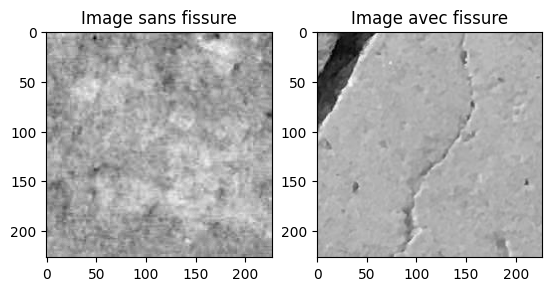

In [ ]:
# visualisation des deux images
plt.subplot(1, 2, 1)
plt.imshow(image0.permute(1, 2, 0), cmap='gray')
plt.title('Image sans fissure')

plt.subplot(1, 2, 2)
plt.imshow(image1.permute(1, 2, 0), cmap='gray')
plt.title('Image avec fissure')
plt.show()



In [ ]:
# Classification de l'image0 ( sans fissure)
pred_image0 = predict_image(image0, model)
print(pred_image0)

0.0


In [ ]:
# Classification de l'image1
pred_image1 = predict_image(image1, model)
print(pred_image1)

1.0


Pour nos deux images de test, le modèle les a correctement. C'est déjà un bon signe. Cependant, pour mieux évaluer les performances du modèle, nous allons le tester sur l'ensemble de nos données de test.

### Test du modèle:

Nous créons maintenant une fonction qui va pouvoir tester le modèle sur notre jeu de données de test.

In [ ]:
def test_model(model, test_dataset, batch_size):
    """
    Évalue les performances d'un modèle sur un jeu de données de test.

    Args:
        model (torch.nn.Module): Le modèle de deep learning à tester.
        test_dataset (torch.utils.data.Dataset): Le jeu de données de test.
        batch_size (int): La taille des lots à utiliser pour le DataLoader.

    Returns:
        float: La précision (accuracy) du modèle sur le jeu de données de test.

    """
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluation du modèle
    model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            # Move data to the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images).view(-1)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)

            # Accuracy computation
            correct_predictions += (pred == labels).sum().item()
            total_samples += labels.size(0)

    test_acc = correct_predictions / total_samples

    return test_acc


In [ ]:

test_model(model, test_dataset, batch_size)

0.995

Après avoir appliqué notre modèle sur le jeu de données de test, nous avons obtenu une précision (accuracy) de 99,5 %. Ce résultat indique que le modèle est capable de classer correctement la grande majorité des exemples de test, démontrant ainsi une excellente performance.

Toutefois, il est important de noter que cette performance doit être interprétée avec prudence. Une précision aussi élevée pourrait être influencée des facteurs comme la diversité des données : Si les données de test sont trop similaires aux données d'entraînement.

# **Conclusion**

L’objectif de ce projet était de classifier des images en identifiant celles qui présentent des fissures. Pour y parvenir, nous avons suivi plusieurs étapes :

Nous avons exploré nos données, composées d’images avec fissures et d’images sans fissures. Nous avons ensuite créé un modèle de réseau de neurones convolutifs (CNN) pour effectuer cette tâche. Après l’entraînement, nous avons testé notre modèle sur un jeu de données de test et obtenu une précision (accuracy) de **99,5 %**, ce qui est un résultat très satisfaisant.

Cependant, pour confirmer ces résultats et améliorer notre modèle, plusieurs pistes sont envisageables :  
- Expérimenter avec des modèles de segmentation pour localiser les fissures dans les images.  
- Utiliser des architectures plus avancées ou des modèles préentraînés pour affiner les performances.  
- Enrichir et diversifier le jeu de données par de la data augmentation pour augmenter la diversité des exemples d'entraînement et améliorer la robustesse et la généralisation du modèle.  

Ce projet illustre l’efficacité du deep learning pour la classification d’images et ouvre la voie à des applications pratiques, comme la détection automatique de défauts dans les infrastructures.  
